In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid, get_circular_mask

from scipy.linalg import hadamard

from numpy.ma import masked_array
import os.path as op
from ekarus.e2e.utils import my_fits_package as myfits


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize], 
                                cmap='twilight', vmin= -24)
    plt.title(title)
    plt.xlabel(xp.asnumpy(xlabel))
    plt.ylabel(xp.asnumpy(ylabel))
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(xp.asnumpy(zlabel))

def showZoomCenter(image, pixelSize, maxValLog=None, red=0.2, mask=None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-red)), int(imageHalfSizeInPoints*(1+red))]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxValLog is None:
        maxValLog = xp.max(imageZoomedLog)
    imageZoomedLog = xp.asnumpy(imageZoomedLog-maxValLog)
    if mask is not None:
        imageZoomedLog = masked_array(imageZoomedLog, mask=xp.asnumpy(1-mask[roi[0]: roi[1], roi[0]:roi[1]]))
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

In [3]:
def lyot_coronograph(focal_field, occulter_radius, lyot_stop:float=0.95, oversampling:int=4):
    focal_mask = get_circular_mask(focal_field.shape,mask_radius=occulter_radius*oversampling)
    lyot_stop = 1-get_circular_mask(focal_field.shape,mask_radius=lyot_stop*max(focal_field.shape)*oversampling)
    field_after_stop = focal_field * focal_mask
    pupil = xp.fft.ifft2(xp.fft.ifftshift(field_after_stop))
    lyot_pupil = pupil * lyot_stop
    coro_focal_field = xp.fft.fftshift(xp.fft.fft2(lyot_pupil))
    coro_psf = xp.abs(coro_focal_field)**2
    return coro_psf

def knife_edge_coronograph(focal_field, iwa:float, owa:float, f_edge:float, oversampling:int=4):
    X,_ = image_grid(focal_field.shape,recenter=True)
    knife_edge = (X<f_edge*oversampling)
    iwa_stop = get_circular_mask(focal_field.shape,mask_radius=iwa*oversampling)
    owa_stop= 1-get_circular_mask(focal_field.shape,mask_radius=owa*oversampling)
    lyot_stop = 1-xp.logical_xor(iwa_stop, owa_stop)
    field_after_mask = focal_field * knife_edge
    pupil = xp.fft.ifft2(xp.fft.ifftshift(field_after_mask))
    lyot_pupil = pupil * lyot_stop
    coro_focal_field = xp.fft.fftshift(xp.fft.fft2(lyot_pupil))
    coro_psf = xp.abs(coro_focal_field)**2
    return coro_psf

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Unobscured actuators: 768/820
Fried parameter is: 5.0 [cm] (seeing = 2.02")


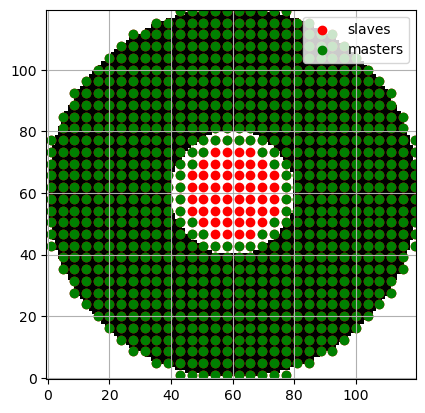

In [4]:
ssao = SingleStageAO(tn='high_contrast')
ssao.initialize_turbulence('ekarus_5cm')
# KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=2)

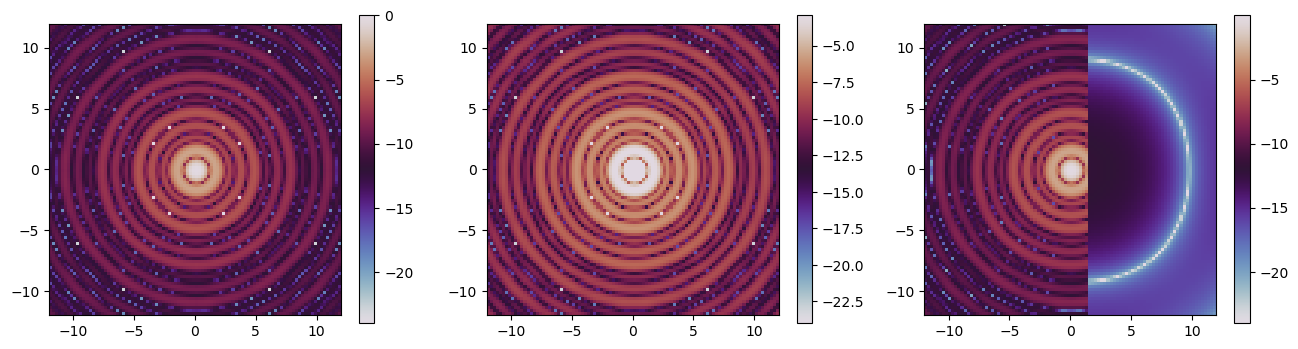

In [5]:
oversampling = 4
input_field = (1-ssao.cmask) * xp.exp(1j*xp.zeros(ssao.cmask.shape))
padded_field = xp.pad(input_field, pad_width=(oversampling-1)*int(max(ssao.cmask.shape))//2, mode='constant', constant_values=0.0)
focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
coro_psf = lyot_coronograph(focal_field, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
ke_psf = knife_edge_coronograph(focal_field, iwa=2, owa=62, f_edge=1.5)
psf = xp.abs(focal_field**2)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
showZoomCenter(psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,2)
showZoomCenter(coro_psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,3)
showZoomCenter(ke_psf, 1/oversampling, xp.max(xp.log(psf)))

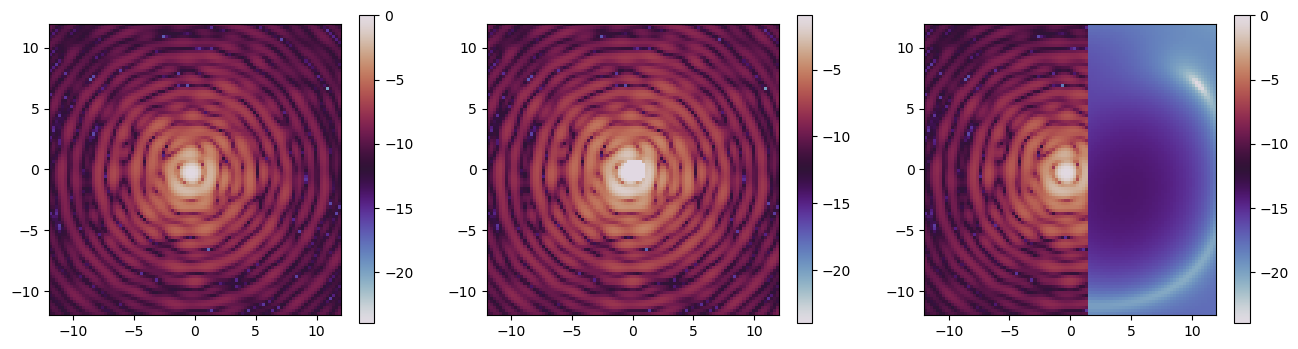

In [6]:
atmo_phase = ssao.get_phasescreen_at_time(0.0)/10
phi = (atmo_phase - xp.mean(atmo_phase))
lambdaInM = 800e-9
phi *= 2*xp.pi/lambdaInM

oversampling = 4
input_field = (1-ssao.cmask) * xp.exp(1j*phi)
padded_field = xp.pad(input_field, pad_width=(oversampling-1)*int(max(ssao.cmask.shape))//2, mode='constant', constant_values=0.0)
focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
coro_psf = lyot_coronograph(focal_field, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
ke_psf = knife_edge_coronograph(focal_field, iwa=2, owa=62, f_edge=1.5)
psf = xp.abs(focal_field**2)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
showZoomCenter(psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,2)
showZoomCenter(coro_psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,3)
showZoomCenter(ke_psf, 1/oversampling, xp.max(xp.log(psf)))

In [7]:
def get_anular_roi(field_shape,iwa,owa,oversampling):

    new_shape = (field_shape[0]*oversampling,field_shape[1]*oversampling)

    iwa_stop = get_circular_mask(new_shape,mask_radius=iwa*oversampling)
    owa_stop= 1-get_circular_mask(new_shape,mask_radius=owa*oversampling)

    roi = xp.logical_and(iwa_stop, owa_stop)

    plt.figure(figsize=(12,5))    
    plt.subplot(1,2,1)
    plt.imshow(xp.asnumpy(roi),origin='lower',cmap='grey')
    plt.subplot(1,2,2)
    showZoomCenter(roi,1/oversampling)

    return roi

In [8]:
hadamat = hadamard(2**xp.ceil(xp.log(ssao.dm.Nacts)/xp.log(2)))
hadamat = hadamat[1:ssao.dm.Nacts+1,:]
hadamat = hadamat[:,1:ssao.dm.Nacts+1]

occulter_radius = 1
lyot_stop = 1.0

def get_psf_from_phase(phase, lambdaInM, occulter_radius, lyot_stop, oversampling):
    m2rad = 2*xp.pi/lambdaInM    
    phase_2d = reshape_on_mask(phase, ssao.dm.mask)
    pad_width = (oversampling-1)*int(max(ssao.cmask.shape))//2
    input_field = (1-ssao.cmask) * xp.exp(1j*phase_2d*m2rad, dtype=xp.cfloat)
    padded_field = xp.pad(input_field, pad_width=pad_width, mode='constant', constant_values=0.0)
    focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
    psf = abs(focal_field)**2
    coro_psf = lyot_coronograph(focal_field, occulter_radius=occulter_radius, lyot_stop=lyot_stop, oversampling=oversampling)
    return psf, coro_psf

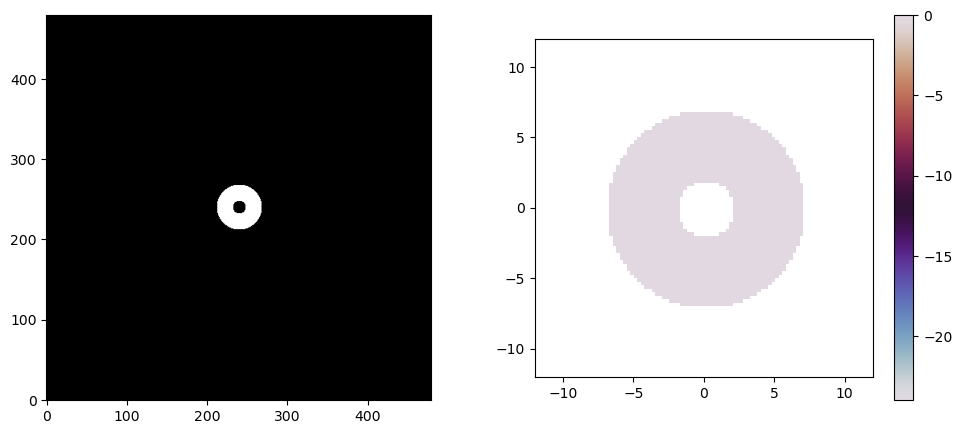

In [9]:
roi = get_anular_roi(input_field.shape,iwa=2,owa=7,oversampling=oversampling)

Text(0.5, 1.0, 'zero')

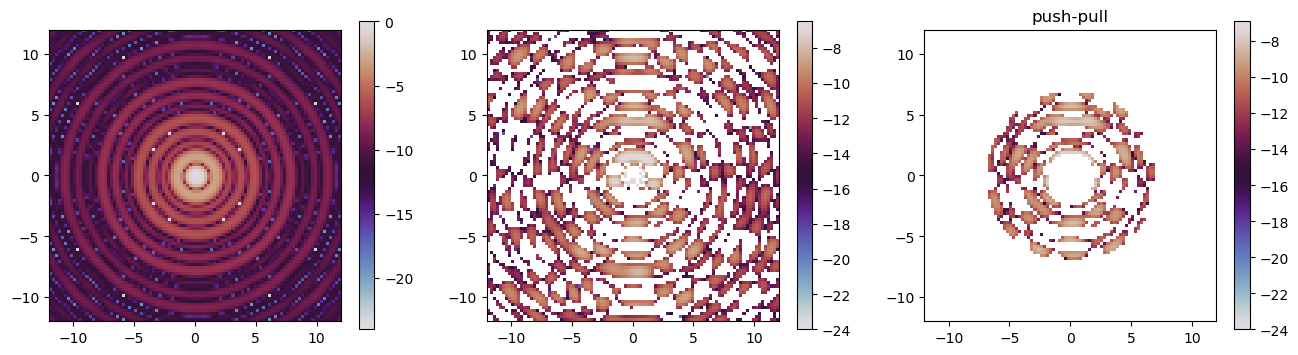

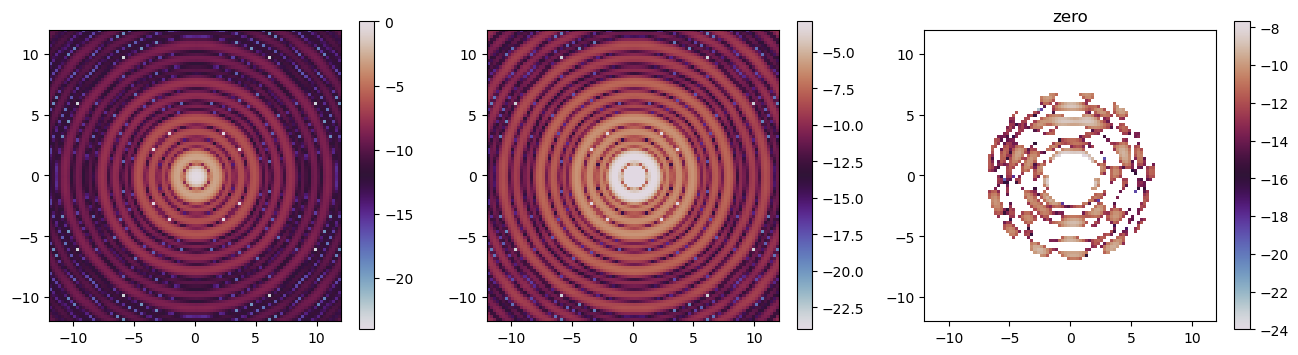

In [10]:
amp = 1e-8
cmd = xp.asarray(hadamat[12,:])*amp
shape = ssao.dm.IFF @ cmd

push_psf, push_coro_psf = get_psf_from_phase(shape, lambdaInM, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
push_roi_psf = push_coro_psf[~roi]

pull_psf, pull_coro_psf = get_psf_from_phase(-shape, lambdaInM, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
pull_roi_psf = pull_coro_psf[~roi]

psf, coro_psf = get_psf_from_phase(shape*0, lambdaInM, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
roi_psf = coro_psf[~roi]

droi = (push_roi_psf - pull_roi_psf)/(2*amp)
droi_noncoro = (push_psf[~roi]-pull_psf[~roi])/(2*amp)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
showZoomCenter(psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,2)
showZoomCenter(push_coro_psf-pull_coro_psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,3)
showZoomCenter(push_coro_psf-pull_coro_psf, 1/oversampling, xp.max(xp.log(psf)), mask=roi)
plt.title('push-pull')

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
showZoomCenter(psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,2)
showZoomCenter(coro_psf, 1/oversampling, xp.max(xp.log(psf)))
plt.subplot(1,3,3)
showZoomCenter(push_psf-psf, 1/oversampling, xp.max(xp.log(psf)), mask=roi)
plt.title('zero')

[-7.12859779e-08 -6.93219003e-08 -6.66321605e-08 -6.32304029e-08
 -5.91408543e-08 -5.43980684e-08 -4.90464876e-08 -4.31398415e-08
 -3.67403820e-08 -2.99179624e-08 -2.27489894e-08 -1.53152585e-08
 -7.70269053e-09  1.06689600e-22  7.70269053e-09  1.53152585e-08
  2.27489894e-08  2.99179624e-08  3.67403820e-08  4.31398415e-08
  4.90464876e-08  5.43980684e-08  5.91408543e-08  6.32304029e-08
  6.66321605e-08  6.93219003e-08  7.12859779e-08]


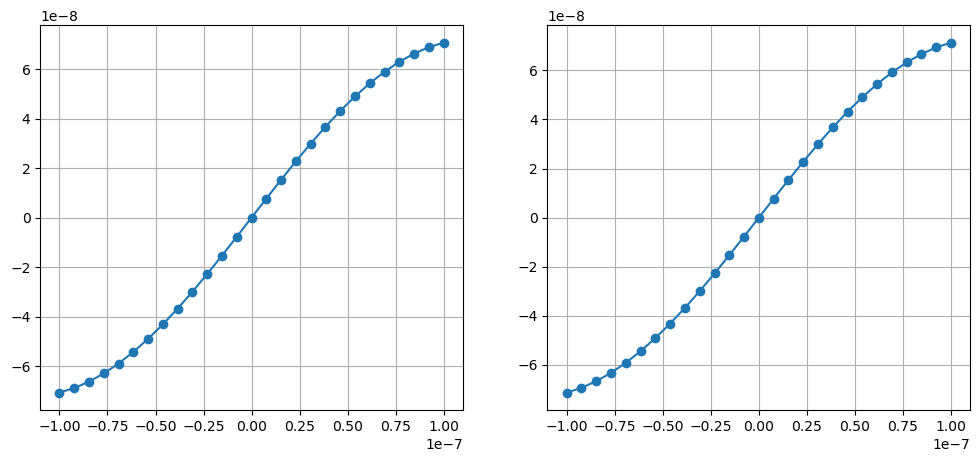

In [11]:
max_amp = 1e-7
amps = xp.linspace(-max_amp,max_amp,27,endpoint=True)
meas = xp.zeros_like(amps)
nc_meas = xp.zeros_like(amps)

ref_noncoro_psf, ref_coro_psf = get_psf_from_phase(shape*0, lambdaInM, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
ref_coro_roi = ref_coro_psf[~roi]
ref_noncoro_roi = ref_noncoro_psf[~roi]

dark_inv = xp.linalg.pinv(xp.reshape(droi,[len(droi),1]))
noncoro_inv = xp.linalg.pinv(xp.reshape(droi_noncoro,[len(droi),1]))

for k,amp in enumerate(amps):
    cmd = xp.asarray(hadamat[12,:])*amp
    shape = ssao.dm.IFF @ cmd
    noncoro_psf, coro_psf = get_psf_from_phase(shape, lambdaInM, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
    roi_psf = coro_psf[~roi]
    delta_roi = roi_psf - ref_coro_roi
    meas[k] = dark_inv @ delta_roi#xp.dot((1/droi).T,delta_roi)
    nc_delta_roi = noncoro_psf[~roi] - ref_noncoro_roi
    nc_meas[k] = noncoro_inv @ nc_delta_roi

print(nc_meas)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(amps),xp.asnumpy(meas),'-o')
plt.grid()
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(amps),xp.asnumpy(nc_meas),'-o')
plt.grid()

(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (128340, 819)
(128340,) (12834

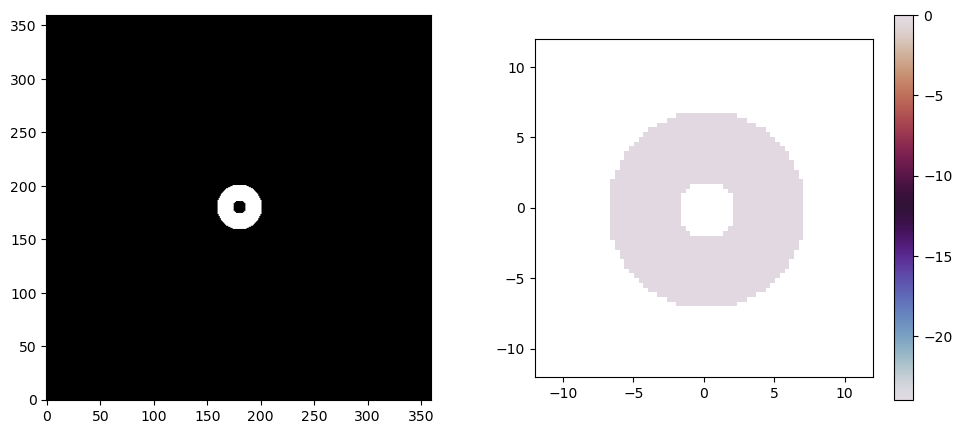

In [ ]:
filename = op.join(ssao.savecalibpath,'coro_psf_intmat.fits')

amp = 1e-8
occulter_radius = 1
lyot_stop = 1.0
oversampling = 3
roi = get_anular_roi(input_field.shape,iwa=2,owa=7,oversampling=oversampling)

try:
    IntMat = myfits.read_fits(filename)
except FileNotFoundError:
    hadamat = hadamard(2**xp.ceil(xp.log(ssao.dm.Nacts)/xp.log(2)))
    hadamat = hadamat[1:ssao.dm.Nacts+1,:]
    hadamat = hadamat[:,1:ssao.dm.Nacts+1]

    IntMat = xp.zeros([int(xp.sum(1-roi)),ssao.dm.Nacts-1])

    for j in range(ssao.dm.Nacts-1):
        dm_cmd = xp.asarray(hadamat[j,:])*amp
        mode = ssao.dm.IFF @ dm_cmd
        push_psf, push_coro_psf = get_psf_from_phase(shape, lambdaInM, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
        push_roi_psf = push_coro_psf[~roi]
        pull_psf, pull_coro_psf = get_psf_from_phase(-shape, lambdaInM, occulter_radius=1, lyot_stop=1.0, oversampling=oversampling)
        pull_roi_psf = pull_coro_psf[~roi]
        IntMat[:,j] = (push_roi_psf-pull_roi_psf)/(2*amp)
    myfits.save_fits(filename, IntMat)
    

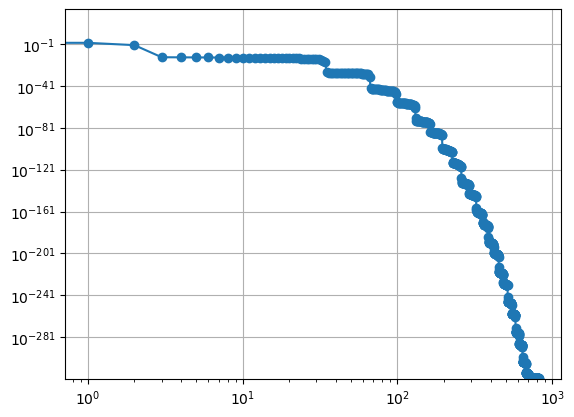

In [16]:
U,D,V = xp.linalg.svd(IntMat,full_matrices=False)

plt.figure()
plt.plot(xp.asnumpy(D),'-o')
plt.grid()
plt.xscale('log')
plt.yscale('log')

128340 (128340, 819) [-1.22124533e-15 -2.45102804e-01 -1.65609762e+00 -1.17128781e+00
 -1.64783855e-02  9.60072623e-01 -1.46930650e+00  7.79167639e-01
 -3.27067061e-01 -6.76425327e-01  1.29041457e+00 -1.14320578e+00
  1.20800695e+00  3.46768148e-01  2.29108204e-01 -8.07332414e-01
 -2.90395988e-01 -4.15210517e-03 -8.52663117e-01  1.44821491e+00
 -1.24216160e+00 -3.03819476e-01  7.51192881e-01 -6.52636555e-01
  1.50768040e+00 -1.60406386e+00 -6.08691658e-01  7.05684101e-01
 -8.29537571e-01  1.66864560e+00  9.33496704e-01 -1.96860329e+00
 -2.31796347e-01 -3.25887002e-01  3.26530811e-01 -7.48805086e-01
 -1.43832148e-01  1.73977633e+00  1.95075480e+00 -7.37664894e-01
 -4.34089118e-02 -1.50199491e+00 -1.03292314e+00 -9.69031885e-01
 -6.45363882e-01  1.75295308e+00 -9.30584504e-01  3.42018351e-01
  7.19963930e-02 -2.18699858e-01  3.34579377e-01 -9.84553646e-01
  1.04937391e-01 -1.07195819e+00 -1.36431785e+00  7.10010680e-01
 -4.39826142e-02  2.20736281e-01 -1.03449705e+00 -2.27077816e-01
 -2.

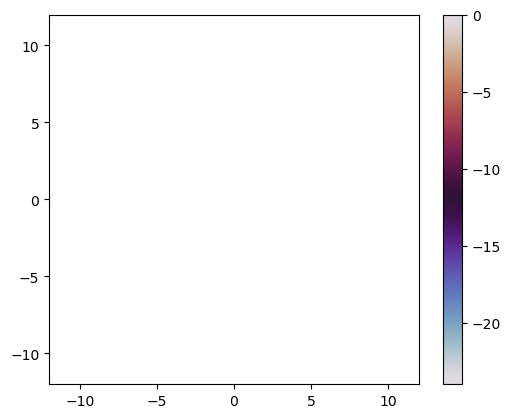

In [17]:
shape_2d = reshape_on_mask(U[:,101], roi)

print(xp.sum(1-roi),U.shape,xp.sum(U,axis=0))

plt.figure()
showZoomCenter(xp.log(shape_2d),1/oversampling)